#  Dutch Restaurant reviews

What are the most negative and positive words in Dutch restaurant reviews?  Analysis using the review texts from reviews scraped already some time ago from the iens.nl website. 

In [7]:
%%capture
######## set up things ####################

# data stuff
import datatable as dt
import pandas as pd
import numpy as np

# plotting stuff
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from plotnine import *
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import pyLDAvis
import pyLDAvis.gensim  # don't skip this

sns.set(rc={'figure.figsize':(10,6)})

# machine leqarning 
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
import xgboost as xgb
from sklearn.metrics import r2_score, mean_absolute_error, median_absolute_error, accuracy_score
from sklearn.linear_model import LogisticRegression

# nlp stuff
from langdetect import detect
import re 
import spacy
nlp = spacy.load("nl_core_news_sm")

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

### Import data 
All reviews are in a zipped csv file, but this file was too big to share on github. 

So I splitted the file into two chunks with the command line tool split. These two parts, restaurantaa and restaurantab, need to be put together first.

In [2]:
!cat restauranta* > all_reviews.zip

In [3]:
### I am using the fread function in datatable to import zipped CSV text file, it is a bit faster than pandas.....
iens = dt.fread('all_reviews.zip')
iens.shape

(211140, 9)

In [4]:
### show some rows
iens.tail(5)

,reviewer,RestaurantNaam,Review,keuken,datum,eten,service,decor,ID
,▪▪▪▪,▪▪▪▪,▪▪▪▪,▪▪▪▪,▪▪▪▪,▪▪▪▪,▪▪▪▪,▪▪▪▪,▪▪▪▪
0,marian_groot,Het Ei Van Columbus,Heerlijk gegeten! Vooraf een heerlijke proeverij w…,FRANS,23/06/2013,8,9,8,211136
1,Kremers,Het Ei Van Columbus,Vanwege verjaardag van Oma uit eten. Keuzemenu bes…,FRANS,15/06/2013,8,8,7,211137
2,Mark-Gerards,Het Ei Van Columbus,Wij hebben hier met 6 personen gegeten en het is o…,FRANS,29/12/2012,10,10,1,211138
3,posth151,Het Ei Van Columbus,De bediening was zonder meer vriendelijk en gastvr…,FRANS,28/12/2012,7,8,6,211139
4,CulinairOegstgeest,Het Ei Van Columbus,Lekker gegeten in dit restaurant op mooie lokatie …,FRANS,09/11/2012,7,7,7,211140


In [5]:
### show one review in full length
iens[3,2]

"Wat moet je hier nu weer mee?Goede cijfers op de Iens app, maar al schrijvende komt er weer een proest van humoristische verbazing boven. Dit is een leuke poging tot restaurant, met niet goed opgeleid personeel dat wel heel erg haar best doet en een maaltijd die ternauwernood volstaat voor de prijs.Matias zit aan een drukke straat met heel veel restaurantjes, de proppers staan voor de deur. Dit was onze 2e keus, maar we moesten te lang wachten bij onze 1e keus voor spareribs en cocktails. Toen wij aankwamen, na een hele leuke dag Rijksmuseum, zaten er uitsluitend toeristen binnen. De groep Amerikaanse jongeren waren over de korting aan het bakkeleien, waarmee blijkbaar geadverteerd werd buiten.Dit restaurantje is niet groot, een tafel op 10. Het personeel telde 6 tot 8 mensen, zo telde ik snel. Er was niet veel te doen, dus hingen ze een beetje rond. Wel heel vriendelijk overigens.De maaltijden zijn Mexicaans, met was Oosterse invloeden. Margarita's zijn goed, verhoudingsgewijs duur. 

In [5]:
reviews = iens.to_pandas()

#### Language detection

We focus on Dutch reviews only. Use the `langdetect`package to detect the language of all reviews. This will take some time to process all 211K reviews. almost 25 min on my laptop

In [6]:
%%time
reviews["language"] = reviews.Review.apply(detect)

CPU times: user 24min 39s, sys: 8.36 s, total: 24min 47s
Wall time: 24min 51s


In [7]:
reviews.language.value_counts()

nl    210354
af       485
en       288
no         5
de         3
so         2
it         2
sl         1
Name: language, dtype: int64

In [8]:
### take only Dutch reviews with non missing 'eten' (food) score
reviews_NL = (
    reviews
    .query('language =="nl"')
    .dropna(subset=['eten', 'Review'])
)
reviews_NL.to_pickle("reviews_NL.pck")

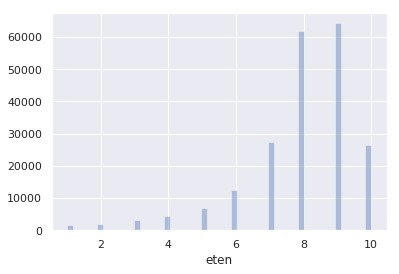

In [9]:
### Overview of the score given
sns.distplot(reviews_NL.eten, kde = False)

In [10]:
### example reviews with bad score
pd.options.display.max_colwidth = 1000
reviews_NL.query('eten < 4').sample(5)[["Review", "eten"]]

,Review,eten
144564,"Wat een drama, dat Maz Mez. Hebben er gegeten met een Groupon-deal. Maar goed dat er voor de deur een supermarkt zit die ’s avonds open is, want daar hebben we snel nog even wat te eten gehaald omdat we nog steeds honger hadden. We voelen ons echt zwaar afgezet met deze deal. Honderd euro waard? Ja, wel als je dan per persoon 10 tapas mag bestellen (zoals bij elk normaal tapasrestaurant), of in elk geval 10 tapas van voldoende grootte krijgt. Maar 1 inktvisringetje per persoon noem ik dus geen tapas. En een half geitenkaaskroketje p.p. ook niet. Of vier minuscule schijfjes stokbrood om de ‘aioli’ in te dopen (een substantie die trouwens weinig met echte aioli te maken had). Of patatas bravas met een soort tomatenpuree? Wij gaan voortaan toch maar weer naar een tapasrestaurant met minder pretenties waar je wel waar voor je geld krijgt.",2.0
110089,"Het eten was van slechte kwaliteit, salade zonder dressing, fish ribs and wings hield in: klein stukje spare rib wat erg droog was, 3 garnalen(die wel smaakten) en 2 kipvleugeltjes die flauw waren. Toetje pancake met bosvruchten dressing???? Geen bosvruchten dressing te zien, wel een rode streep over het bord, maar dat smaakte melig/zout/onbestendig. Dame Blanche leek van oud vanille ijs. Koffie was zo bitter dat heb ik nog nooit meegemaakt. De droge huiswijn smaakte naar bier, de zoete was wel te drinken. Ze hadden waarschijnlijk personeelstekort want na 1 uur hadden we nog niet eens een voorgerecht, laat staan stukje brood gehad. We gaan regelmatig uit eten, maar dit was wel het slechtste wat we meegemaakt hebben. Ook geen gezellig restaurant om binnen te zitten, grote ruimte met bar.",2.0
65115,"Zeer onvriendelijke eigenaar. Prijs kwaliteit buiten proporties, 9,50 voor 5 garnalen? Er mag meer niet dan wel. De klant Is niet welkom en al helemaal niet koning.",2.0
31339,Als vegetariër hier Niet eten een drie Luik ik vette noedels en loempia waarvan ze weigeren toe te geven dat het er niet uitzag (en smaak was nog slechter) de Quick was oké maar omdat de rest zo slecht was ook daar niet van genoten,1.0
140998,"Helaas geen goede ervaring. Eten is welliswaar betaalbaar, maar van zeer matige kwaliteit. Draadjesvlees leek uit een kant en klaar groothandel bakje, veel stukken vet, amper een half champignonnetje in de ''saus''. Partner had een smakeloze kipsate waar ook de nodige stukken vet nog aanzaten. Frites qua smaak ook beneden peil. Helaas een verslechtering tov de vorige eigenaar. Hier komen we niet meer terug.",3.0


## Preparing text for further analysis

In [2]:
reviews_nl = pd.read_pickle("reviews_NL.pck")

### count the number of words per review

In [4]:
%%time
### get the number of words per review
reviews_nl = (
    reviews_nl
    .assign(
        n_words = reviews_nl.Review.apply(lambda x : len(re.findall(r'\w+', x)))
    )
)

CPU times: user 4.61 s, sys: 31.2 ms, total: 4.64 s
Wall time: 4.46 s


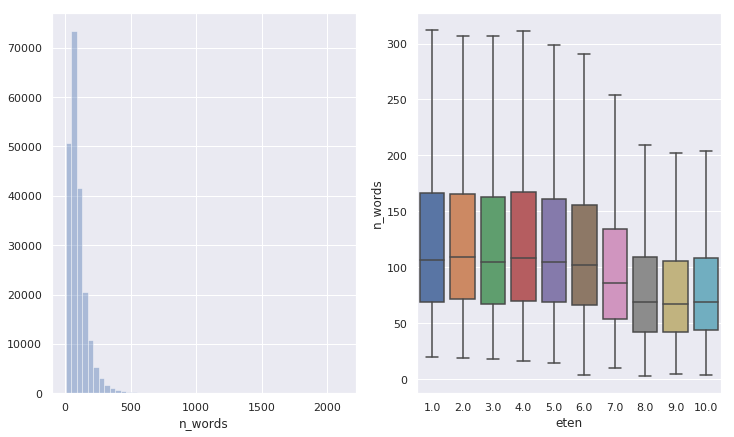

In [5]:
fig, axes = plt.subplots(1,2,  figsize=(12,7))

sns.distplot(reviews_nl.n_words, kde=False, ax=axes[0])
sns.boxplot(y = "n_words", x = "eten", data = reviews_nl, showfliers=False, ax=axes[1])

seems that people who give lower scores ( eten <7) tend to use more words to write the review

/home/longhowlam/anaconda3/lib/python3.7/site-packages/plotnine/stats/smoothers.py:146: UserWarning: Confidence intervals are not yet implementedfor lowess smoothings.
  warnings.warn("Confidence intervals are not yet implemented"


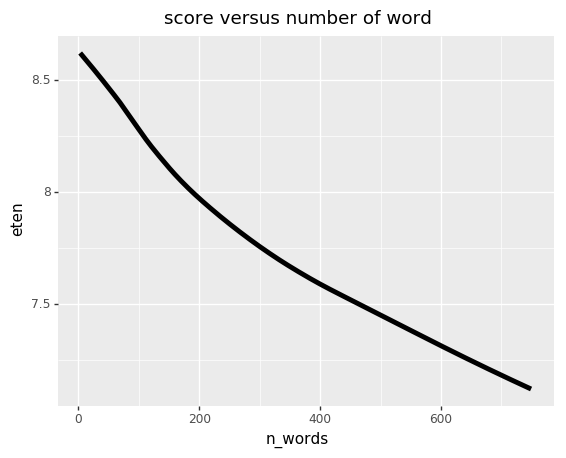

<ggplot: (-9223363266091101103)>

In [45]:
(
    ggplot(reviews_nl.query('n_words < 750'), aes('n_words', 'eten' )) 
    + stat_smooth(method='lowess', size = 2)
    + ggtitle("score versus number of word")
)

### remove stop words and punctuation

In [5]:
def clean_review(x):
    doc = nlp(x)
    tokens = [token.text for token in doc if (not token.is_punct) & (not token.is_stop)]
    return " ".join(tokens)

In [15]:
clean_review(reviews_nl.iloc[3,2])

"Wat weer mee?Goede cijfers Iens app schrijvende komt weer proest humoristische verbazing boven Dit leuke poging restaurant goed opgeleid personeel heel erg best doet maaltijd ternauwernood volstaat prijs Matias zit drukke straat heel restaurantjes proppers staan deur Dit onze 2e keus moesten lang wachten onze 1e keus spareribs cocktails Toen aankwamen hele leuke dag Rijksmuseum zaten uitsluitend toeristen binnen De groep Amerikaanse jongeren korting bakkeleien waarmee blijkbaar geadverteerd buiten Dit restaurantje groot tafel 10 Het personeel telde 6 8 mensen telde snel Er hingen beetje rond Wel heel vriendelijk overigens De maaltijden Mexicaans Oosterse invloeden Margarita 's goed verhoudingsgewijs duur Enchilada 's Fajitas pollo beide bord vol eten aardig smaakvol weinig inspiratie beter zeg hehe).We verwachtten sfeervolle Caribische muziek helaas De radio stond lekker handig nieuws hebt gemist Een grinnik moeilijk onderdrukken In geluidsinstallatie mogen investeren klonk muziek str

In [6]:
%%time
review_sample = reviews_nl.sample(20000)
review_sample = (
    review_sample
    .assign(
        cleaned_review = review_sample.Review.apply(clean_review)
    )
)  

CPU times: user 39min 17s, sys: 1min 4s, total: 40min 21s
Wall time: 10min 33s


In [4]:
review_sample = pd.read_pickle("reviews_NL2.pck")

In [5]:
pd.options.display.max_colwidth = 1000
review_sample[["Review", "cleaned_review"]].sample(3)

,Review,cleaned_review
183046,"Uiteraard is de plek super. De bediening is erg aardig en behulpzaam. Maar het eten vind ik matig te noemen. Niet alleen vind ik het wat saai en niet hoog op smaak, ik vind de prijzen idioot hoog. 14,50 voor een kleine salade met paddenstoelen en een paar spekjes, is wel heel erg veel geld. De vorige keer dat ik er was, had ik een dik gesneden boterham met wat gerookte forel en die kostte ongeveer 8-9 euro meen ik. Het is dat de plek zo leuk is en dat ik graag wandel in de Horsten, maar als er meer keuze was qua horeca, zou ik er nooit meer komen, eerlijk gezegd. En als ik een tip mag geven: doe iets aan dat toilet, het is rommelig en oogt niet hygiënisch.","Uiteraard plek super De bediening erg aardig behulpzaam Maar eten vind matig noemen Niet alleen vind saai hoog smaak vind prijzen idioot hoog 14,50 kleine salade paddenstoelen paar spekjes heel erg geld De vorige keer dik gesneden boterham gerookte forel kostte ongeveer 8 9 euro meen Het plek leuk graag wandel Horsten keuze qua horeca nooit komen eerlijk gezegd En tip mag geven doe toilet rommelig oogt hygiënisch"
50509,"Afgelopen weekend waren wij met ons gezin (man, vrouw en 3 kinderen) wezen eten. Wij zijn hier vaak geweest maar moeten helaas constateren dat de kwaliteit van het eten erg achteruit is gegaan. De sushi leek niet vers, het vlees was niet warm, etc. Maar wat nog erger was dat in de baminoodle van mij vrouw haren zaten. Wij spraken het personeel erop aan, maar daar werd niets mee gedaan. Ik vind het personeel nogal onpersoonlijk en word je als een nummertje behandeld. Ik denk dat Shabu Shabu door hun succes nogal arrogant wordt en totaal geen service geeft naar haar klanten. Het enige wat telt is het geld, wat bijvoorbeeld tot uitdrukking komt in de constante vraag of je nog wilt drinken (daar verdienen zij veel op). Jammer maar voor mij geen Shabu Shabu meer.",Afgelopen weekend gezin man vrouw 3 kinderen eten Wij vaak moeten helaas constateren kwaliteit eten erg achteruit gegaan De sushi leek vers vlees warm etc Maar erger baminoodle vrouw haren zaten Wij spraken personeel erop mee gedaan Ik vind personeel nogal onpersoonlijk word nummertje behandeld Ik denk Shabu Shabu succes nogal arrogant wordt totaal service geeft klanten Het enige telt geld bijvoorbeeld uitdrukking komt constante vraag wilt drinken verdienen Jammer Shabu Shabu
83478,"""Nog nooit zo'n onsmakelijke \k""rabsalade\"" gegeten. Krab met kerrie! Geen krab geproefd dus. We hebben wel vaker in dit restaurant gegeten met zeer uiteenlopende ervaringen. Deze keer zat het niet mee dus. Prijs/kwaliteit verhouding volledig scheef. Bediening was OK. Bij het afrekenen (aan de receptie....) toch maar even mijn hart gelucht. \""Ik zal het doorgeven aan de chef\"" was de nogal laconieke reactie. We komen nog wel eens terug als het terras weer open is. Met mooi uitzicht op het water en twee kroketten met bruinbrood. Helft van de prijs van de kerriekrab maar wel 10 keer zo lekker.""","Nog nooit zo'n onsmakelijke \k""rabsalade\ gegeten Krab kerrie Geen krab geproefd We vaker restaurant gegeten zeer uiteenlopende ervaringen Deze keer zat mee Prijs kwaliteit verhouding volledig scheef Bediening OK Bij afrekenen receptie even hart gelucht \""Ik doorgeven chef\ nogal laconieke reactie We komen terug terras weer open Met mooi uitzicht water twee kroketten bruinbrood Helft prijs kerriekrab 10 keer lekker"


### Count vectorizer for regularized logistic regression

In [8]:
### create binary target, bad reviews if score is < 6
review_sample = review_sample.assign(target = np.where(review_sample.eten < 6,1,0))

In [9]:
review_sample.target.value_counts()

0    18368
1     1632
Name: target, dtype: int64

In [10]:
cv = CountVectorizer(ngram_range=(1,2))
cv.fit(review_sample.cleaned_review)
X = cv.transform(review_sample.cleaned_review)
target = review_sample.target

X_train, X_val, y_train, y_val = train_test_split(
    X, target, train_size = 0.75
)

In [11]:
X_train.shape

(15000, 618873)

### Logistic regression

In [12]:
for c in [0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 1]:
    lr = LogisticRegression(C=c)
    lr.fit(X_train, y_train)
    print (
        "Accuracy for C=%s: %s" 
        % (c, accuracy_score(y_val, lr.predict(X_val)))
    )

/home/longhowlam/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy for C=0.01: 0.93
Accuracy for C=0.05: 0.9406
Accuracy for C=0.25: 0.9406
Accuracy for C=0.5: 0.9418
Accuracy for C=0.75: 0.9422
Accuracy for C=0.95: 0.9422
Accuracy for C=1: 0.9422


In [13]:
final_model = LogisticRegression(C=0.5)
final_model.fit(X_train, y_train)

LogisticRegression(C=0.5, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

#### Look at top words that are distinguishes bad reviews and good reviews
Extract coefficient estimate from the logistic regression and see the biggest and smallest coefficients

In [14]:
#### The best and worst words......
wordcoef = pd.DataFrame({
    "word": cv.get_feature_names(),
    "coef":  final_model.coef_[0]
})

print("Number of coefficients", wordcoef.shape)
print("Number of nonzero coefficients", wordcoef.query('(coef < 0) | (coef > 0)'). shape)

wordcoef.sort_values(by="coef", inplace = True)

Number of coefficients (618873, 2)
Number of nonzero coefficients (493450, 2)


In [15]:
wordcoef.head(10)

,word,coef
230807,heerlijk,-1.634581
232264,heerlijke,-1.068792
416812,prima,-1.011673
314661,lekkere,-1.000687
517821,uitstekend,-0.787339
211754,goed,-0.770328
190838,genoten,-0.744829
506610,top,-0.741548
401201,perfect,-0.724379
560607,voortreffelijk,-0.670975


In [16]:
wordcoef.tail(10)

,word,coef
615396,zout,0.842787
457742,slecht,0.886832
485194,taai,0.914376
122919,droog,0.914603
542586,vet,0.925254
295528,koud,0.941453
311502,leek,0.962216
458162,slechte,0.970242
368063,nooit,1.065318
462850,smakeloos,1.159579


## Word clouds

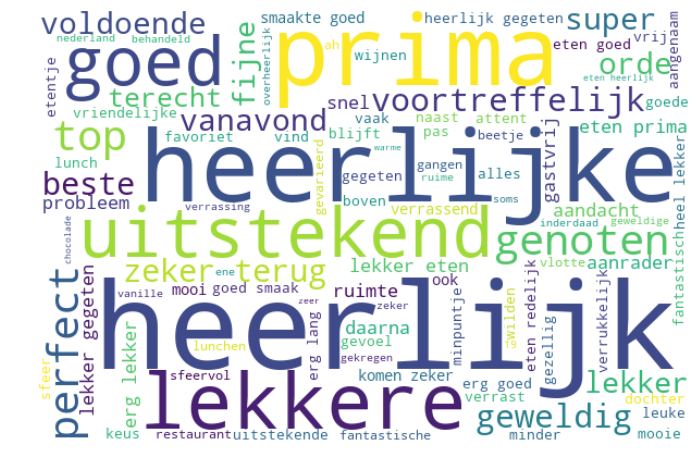

In [17]:
tmp = wordcoef.head(100)
tmp = tmp.assign(freq = -1*tmp.coef)
zz = tmp.set_index('word')["freq"].T.to_dict()

# Create and generate a word cloud image:
tmp = {"A":9, "B":0.10}
wordcloud = WordCloud( background_color="white", height=400, width=600).generate_from_frequencies(zz)
plt.figure(figsize=(12,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

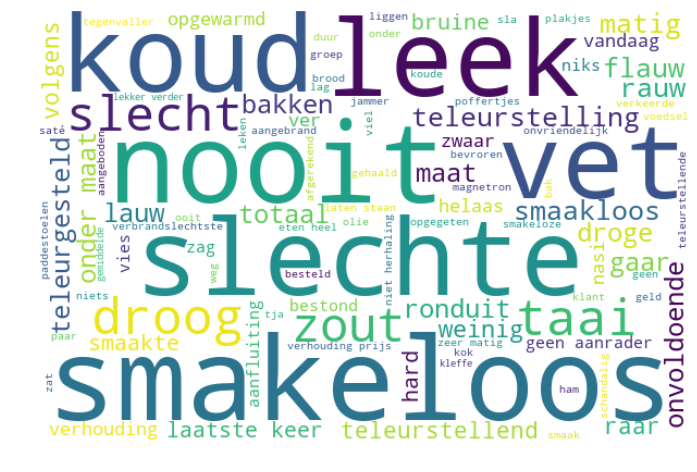

In [18]:
tmp = wordcoef.tail(100)
tmp = tmp.assign(freq = tmp.coef)
zz = tmp.set_index('word')["freq"].T.to_dict()

# Create and generate a word cloud image:
tmp = {"A":9, "B":0.10}
wordcloud = WordCloud( background_color="white", height=400, width=600).generate_from_frequencies(zz)
plt.figure(figsize=(12,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


# Topic modeling